In [14]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import save_image
from crp.image import imgify,vis_opaque_img
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [15]:
notebook_directory = Path().resolve().parent
sys.path.insert(0,str(notebook_directory.parent))

from interpret.XAImethods import XAI
from experiment.helper_functions import load_dict
from sentinelmodels.pretrained_models import buildmodel

In [16]:
config={    
                "root_dir":r'D:/master-thesis/Dataset/anthroprotect',
                "datasplitfilename": r"infos.csv",
                "n_classes":2,
                "datasaved":True,
                "device":"cpu",
                "models":["alexnet","vgg16","resnet18"],
                "modelweightpaths":[r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/alexnet_best_model.pth",
                                    r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/vgg16_best_model.pth",
                                    r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/resnet18_best_model.pth",
                                    ],
                "cmap":"hot",
                "plotmethod":"heat_map"
                }

datafilepath=r"D:/finaldraft/ExplainingWilderness/experiment/Notebooks/data/wilderness_datasample1.pkl"
saved_path="D:/finaldraft/ExplainingWilderness/experiment/Notebooks/temp/heatmaps/"
modelindex=-1
imagename=config["models"][modelindex]

loaded_data = dictionary = load_dict(datafilepath)
# Accessing the loaded images and labels
images = loaded_data["images"][-1,:,:,:].unsqueeze(dim=0).to(config["device"])
#images = loaded_data["images"].to(config["device"])

labels = loaded_data["labels"]

input_image_name="wilderness_data_XAI1.png"
image_path = os.path.join(r"D:/finaldraft/ExplainingWilderness/experiment/Notebooks/temp/",input_image_name)
save_image(F.pad(images, (2, 2, 2, 2), mode='constant', value=0), image_path, nrow=1, padding=0)


In [17]:

model=buildmodel(model_type=config["models"][modelindex],multiclass_channels=config["n_classes"],modelweightpath=config["modelweightpaths"][modelindex]).to(config["device"])

XAImethods=XAI(model,device=config['device'])
del model

XAImethodslist=XAImethods.listofmethods()


In [18]:
print(XAImethodslist)

['Intergrated Gradients', 'NoiseTunnel', 'Guided BackProp', 'Grad SHAP', 'Guided GradCam', 'Deconvolution', 'Occlusion']


In [19]:
methodlist=['Intergrated Gradients','Grad SHAP', 'Guided GradCam','Occlusion']
print("XAI methods",methodlist)
explaination=XAImethods.run_all(images,target=[1],methodlist=methodlist,path=saved_path, filename=imagename, default_cmap=config["cmap"], method=config['plotmethod'],interpolation="area",strides=(3,5,5),sliding_window_shapes=(3,10,10))

XAI methods ['Intergrated Gradients', 'Grad SHAP', 'Guided GradCam', 'Occlusion']


d:\finaldraft\ExplainingWilderness\thesis\Lib\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


In [20]:
from interpret.concept.conceptrelevance import ConceptRelevance
model=buildmodel(model_type=config["models"][modelindex],multiclass_channels=config["n_classes"],modelweightpath=config["modelweightpaths"][modelindex]).to(config["device"])
Concepts=ConceptRelevance(model,device=config["device"])
#del model

In [21]:
recordlayers=list(Concepts.layer_map.keys())
print(recordlayers)

['features.0', 'features.4.0.conv1', 'features.4.0.conv2', 'features.4.1.conv1', 'features.4.1.conv2', 'features.5.0.conv1', 'features.5.0.conv2', 'features.5.0.downsample.0', 'features.5.1.conv1', 'features.5.1.conv2', 'features.6.0.conv1', 'features.6.0.conv2', 'features.6.0.downsample.0', 'features.6.1.conv1', 'features.6.1.conv2', 'features.7.0.conv1', 'features.7.0.conv2', 'features.7.0.downsample.0', 'features.7.1.conv1', 'features.7.1.conv2', 'common_layers.0', 'common_layers.3', 'common_layers.6']


In [22]:
heatmap,relevance,p=Concepts.conditional_relevance(images,condition=[{"y":[1]}],compositename="epsilonplus",canonizerstype=config["models"][modelindex],output_type="max",record_layer=recordlayers)

In [23]:
#from captum.attr import  GuidedBackprop,NoiseTunnel
#ig = GuidedBackprop(model)
#
#nt = NoiseTunnel(ig)
#
#attribution = nt.attribute(images, nt_type='smoothgrad',nt_samples=10, target=1)
#explaination["NoiseTunnel"]=(0,attribution,0)

In [24]:
#from captum.attr import  Occlusion
#oc = Occlusion(model)
#
#attribution = oc.attribute(images, target=1,strides=(3,15,15), sliding_window_shapes=(3,25,25))
#explaination["Occlusion"]=(attribution,0)

In [25]:
#del explaination["NoiseTunnel"]

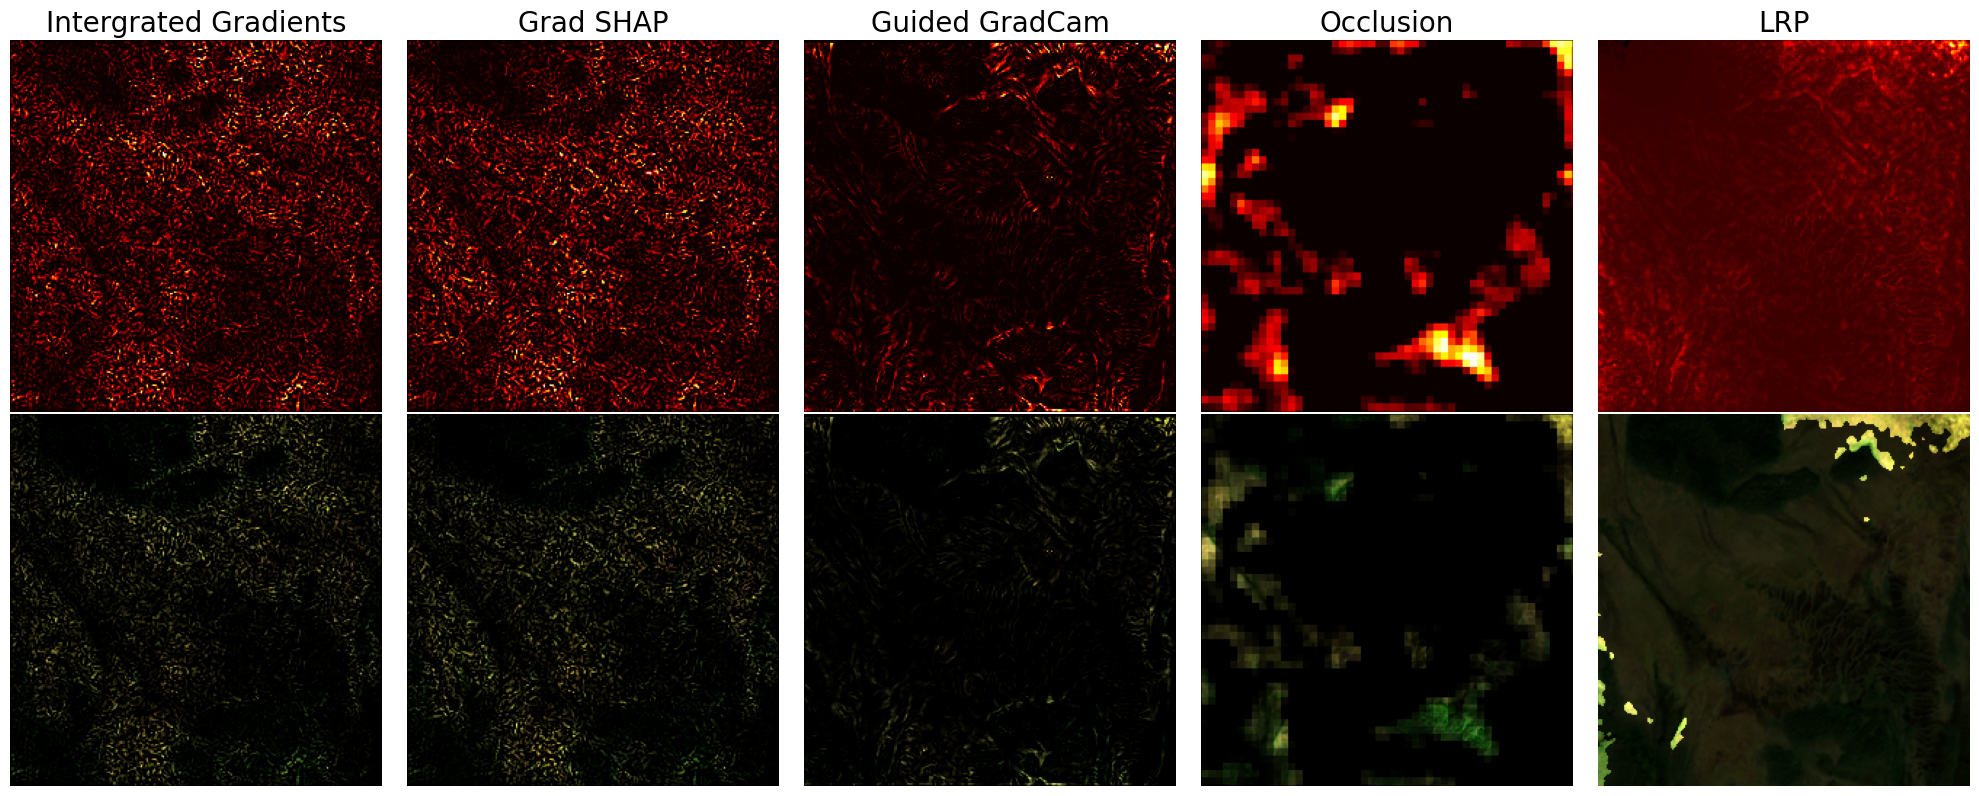

In [26]:
explaination["LRP"]=(0,heatmap,0)
num_images = len(explaination)
fig, axes = plt.subplots(2, num_images, figsize=(num_images * 4, 2 * 4))

# Ensure 'axes' is a 2D array even when num_images is 1
if num_images == 1:
    axes = np.expand_dims(axes, axis=-1)

for i, (title, (attr,hm,hm_mask)) in enumerate(explaination.items()):
    # Generate heatmap and masked image
    if title!="LRP":
        axes[0, i].imshow(hm)
        axes[0, i].set_title(title,size=20)
        axes[0, i].axis('off')  # Turn off axis
        # Plot masked image in the second row
        axes[1, i].imshow(hm_mask)
        axes[1, i].axis('off')  # Turn off axis
    else:
        kernel_size=9
        masked_image = vis_opaque_img(images,hm, alpha=0.15,kernel_size=9)[0]
        axes[0, i].imshow(imgify(hm, cmap="hot", symmetric=False, level=1))
        axes[0, i].set_title(title,size=20)
        axes[0, i].axis('off')  # Turn off axis
        # Plot masked image in the second row
        axes[1, i].imshow(masked_image)
        axes[1, i].axis('off') 

    # Plot heatmap in the first row
     # Turn off axis

plt.tight_layout()
saved_path="D:/finaldraft/ExplainingWilderness/experiment/Notebooks/temp/heatmaps"
plt.savefig(os.path.join(saved_path,"./"+config["models"][modelindex]+"_XAIcomparsion.png"),dpi=600)
plt.show()

In [ ]:
explaination["LRP"]=(heatmap,0)
num_images = len(explaination)
fig, axes = plt.subplots(2, num_images, figsize=(num_images * 4, 2 * 4))

# Ensure 'axes' is a 2D array even when num_images is 1
if num_images == 1:
    axes = np.expand_dims(axes, axis=-1)

for i, (title, (inp, _)) in enumerate(explaination.items()):
    # Generate heatmap and masked image
    if title!="LRP":
        heatmap = inp.sum(dim=1)
        heatmap[heatmap < 0] = 0
        kernel_size=5
    else:
        heatmap = inp
        kernel_size=9
    masked_image = vis_opaque_img(images,heatmap, alpha=0.15,kernel_size=kernel_size)[0]

    # Plot heatmap in the first row
    axes[0, i].imshow(imgify(heatmap, cmap="hot", symmetric=False, level=1))
    axes[0, i].set_title(title,size=20)
    axes[0, i].axis('off')  # Turn off axis
    # Plot masked image in the second row
    axes[1, i].imshow(masked_image)
    axes[1, i].axis('off')  # Turn off axis

plt.tight_layout()
saved_path="D:/finaldraft/ExplainingWilderness/experiment/Notebooks/temp/heatmaps"
plt.savefig(os.path.join(saved_path,"./"+config["models"][modelindex]+"_XAIcomparsion.png"),dpi=600)
plt.show()

In [ ]:
vis_opaque_img(images,abs(torch.ones_like(heatmap)),alpha=0.1,kernel_size=87)[0]

In [ ]:
heatmap.sum()

In [ ]:
saved_path="D:/finaldraft/ExplainingWilderness/experiment/Notebooks/temp/heatmaps"
imgify(heatmap,cmap="hot",symmetric=False,level=1).save(os.path.join(saved_path,"./"+config["models"][modelindex]+"_initlrp_"+str(heatmap.sum())+".png"),format="png",dpi=(400,400))

In [ ]:
topk_c=5
toprelevance_list=Concepts.compute_relevance_maximization(relevance,condlayernames=recordlayers,relevance_type="positive",topk_c=topk_c)

In [ ]:
def generate_maxconcepts(images,layername,channelindexlist,output=[1],compositename="epsilonplus",canonizerstype="vgg16",output_type="max",record_layer=[]):
    concepthm=[]
    for i in range(0,len(channelindexlist)):
        conditions=[]
        conditions += [{"y": output, layername: [channel]} for channel in channelindexlist[i][0]]
        reldheatmap,_,_=Concepts.conditional_relevance(images,condition=conditions,compositename=compositename,canonizerstype=canonizerstype,output_type=output_type,record_layer=record_layer)
        selectedhmconditions = [{"y": output, layername:channelindexlist[i][0]}]
        selectedcondheatmap,scm_relevance,_=Concepts.conditional_relevance(images[i,:,:,:].unsqueeze(dim=0),condition=selectedhmconditions,compositename=compositename,canonizerstype=canonizerstype,output_type=output_type,record_layer=record_layer)
        concepthm.append((reldheatmap,selectedcondheatmap,scm_relevance))
    return concepthm

In [ ]:
print(recordlayers)

In [ ]:
layername=recordlayers[-6:-1]

In [ ]:
layername = ['features.6.1.conv2', 'features.7.0.conv1', 'features.7.0.conv2', 'features.7.1.conv1', 'features.7.1.conv2']

In [ ]:
fig, axs = plt.subplots(len(layername), 5, figsize=(25, len(layername) * 5))

for index, layer in enumerate(reversed(layername)):
    channelsindex = toprelevance_list[layer][0][0]
    conditions = [{"y": 1, layer: [channel]} for channel in channelsindex]
    selectedcondheatmap, scm_relevance, _ = Concepts.conditional_relevance(images, condition=conditions, compositename="epsilonplus", canonizerstype=config["models"][modelindex], record_layer=[layer])

    if selectedcondheatmap.size == 0:
        print(f"No data for layer {layer}")
        continue
    cum=0
    for j in range(min(5, selectedcondheatmap.shape[0])):
        heatmap = imgify(selectedcondheatmap[j, :, :], cmap="hot", symmetric=False, level=1)
        cum+=selectedcondheatmap[j, :, :].sum()
        axs[index, j].imshow(heatmap)
        axs[index, j].set_title("Ch: {} R(x|c{}):{}%".format(channelsindex[j],j,round(selectedcondheatmap[j, :, :].sum().item()*100,2)),size=16)
          # Turn off axis
        if j==0:
           axs[index, j].axis('on')
           axs[index, j].get_yaxis().set_visible(True)
           axs[index, j].set_yticklabels([])
           axs[index, j].get_xaxis().set_visible(False)
        else:
            axs[index, j].axis('off')

    # Label the rows with the layer names
    axs[index, 0].set_ylabel(layer+" R(x|y)="+str(round(cum.item()*100,2))+"%", rotation=90, size=18, labelpad=30)

    for j in range(selectedcondheatmap.shape[0], 5):
        axs[index, j].axis('off')

# Adjust subplot parameters
plt.subplots_adjust(wspace=0, hspace=1.5)  # Adjust space between rows and remove space between columns

plt.tight_layout()
saved_path="D:/finaldraft/ExplainingWilderness/experiment/Notebooks/temp/heatmaps"
plt.savefig(os.path.join(saved_path,"./"+config["models"][modelindex]+"_crp5layers.png"),dpi=600)
plt.show()